<a href="https://colab.research.google.com/github/BhadrinathKS/Brain-Tumor-Detection/blob/main/BrainTumorDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Brain Tumor Detection
---
Author: Bhadrinath Kolluru

Date: 18th July, 2024




# 1) Project Overview & Objectives

The purpose of this project is to build a CNN model that can classify if a brain has a tumor or not based off various MRI scans.

#2) Import Libraries & Connect Data

In [13]:
from google.colab import drive
drive.mount('/content/drive')

# this creates a symbolic link so that now the path /content/gdrive/My\ Drive/ is equal to /mydrive
!ln -s /content/drive/My\ Drive/ /Gdrive
!ls /Gdrive

Mounted at /content/drive
'Colab Notebooks'   MachineLearningProject


In [55]:
# Import Libraries
import os, shutil
import cv2
import glob
import imutils
import xml.etree.ElementTree as ET
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import time
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# Import Keras (VGG-19 Machine Learning Model)
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Flatten, Dense, Dropout
from keras.applications.vgg19 import VGG19
from keras.optimizers import SGD, RMSprop, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# 3) Image Renaming & EDA

In [ ]:
# Renaming all Files

# Yes Directory
tumerous = '/Gdrive/MachineLearningProject/images/datasets/yes/'
countY = 1

for filename in os.listdir(tumerous):
    source = tumerous + filename
    destination = tumerous + "Y_" +str(countY)+".jpg"
    os.rename(source, destination)
    countY+=1
print("All files are renamed in the Yes Directory!\n")

print(". . .\n")

# No Directory
non_tumerous = '/Gdrive/MachineLearningProject/images/datasets/no/'
countN = 1

for filename in os.listdir(non_tumerous):
    source = non_tumerous + filename
    destination = non_tumerous +"N_" +str(countN)+".jpg"
    os.rename(source, destination)
    countN+=1
print("All files are renamed in the No Directory")

All files are renamed in the Yes Directory!

. . .

All files are renamed in the No Directory


In [14]:
# EDA (Exploratory Data Analysis)

Ylist = os.listdir("/Gdrive/MachineLearningProject/images/datasets/yes/")
number_files_yes = len(Ylist)
print("Yes Files: "+str(number_files_yes))


Nlist = os.listdir("/Gdrive/MachineLearningProject/images/datasets/no/")
number_files_no = len(Nlist)
print("No Files: "+str(number_files_no))

Yes Files: 155
No Files: 98


# 4) Data Visualization on chosen sample

Text(0.5, 1.0, 'Count of Tumerous Brain Images')

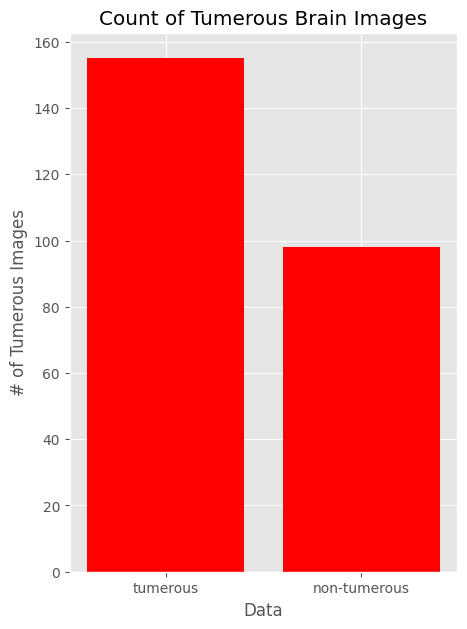

In [ ]:
# Plot Of Original Sample

data = {'tumerous': number_files_yes, 'non-tumerous': number_files_no}

typex = data.keys()
values = data.values()

fig = plt.figure(figsize=(5,7))
plt.bar(typex, values, color="red")
plt.xlabel("Data")
plt.ylabel("# of Tumerous Images")
plt.title("Count of Tumerous Brain Images")

# 5) Data Augmentation

In [ ]:
# Create Timer
def timing(sec_elapsed):
    h = int(sec_elapsed / (60*60))
    m = int(sec_elapsed % (60*60) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{s}"

In [ ]:
# 155(61%), 98(39%)
# There is an imbalance in the sample so it is important to create more images to increase accuracy of the model

def augmented_data(file_dir, n_generated_samples, save_to_dir):
    data_gen = ImageDataGenerator(rotation_range=10,
                      width_shift_range=0.1,
                      height_shift_range=0.1,
                      shear_range=0.1,
                      brightness_range=(0.3, 1.0),
                      horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='nearest')
    for filename in os.listdir(file_dir):
        image = cv2.imread(file_dir + '/' + filename)
        image = image.reshape((1,) + image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i=0
        for batch in data_gen.flow(x = image, batch_size = 1, save_to_dir = save_to_dir, save_prefix = save_prefix, save_format = "jpg"):
            i+=1
            if i>n_generated_samples:
                break

In [ ]:
# Augmentation Start
import time
start_time = time.time()

yes_path = '/Gdrive/MachineLearningProject/images/datasets/yes/'
no_path = '/Gdrive/MachineLearningProject/images/datasets/no/'
augmented_data_path = '/Gdrive/MachineLearningProject/data/augmented_data/'

augmented_data(file_dir = yes_path, n_generated_samples=2, save_to_dir=augmented_data_path+'yes')
augmented_data(file_dir = no_path, n_generated_samples=4, save_to_dir=augmented_data_path+'no')

end_time = time.time()
execution_time = end_time - start_time
print("Sucessful Augmentation!\n")
print(timing(execution_time))

0:1:23.2265784740448


In [ ]:
# Post-Augmentation Results

def data_summary(main_path):
    yes_path = "/Gdrive/MachineLearningProject/data/augmented_data/yes/"
    no_path = "/Gdrive/MachineLearningProject/data/augmented_data/no/"

    n_pos = len(os.listdir(yes_path))
    n_neg = len(os.listdir(no_path))
    n = (n_pos + n_neg)
    pos_per = (n_pos*100/n)
    neg_per = (n_neg*100/n)

    print(f"Number of samples: {n}")
    print(f"Number of positive samples: {n_pos} ({pos_per}%)")
    print(f"Number of negative samples: {n_neg} ({neg_per}%)")

# Show Summary
data_summary(augmented_data_path)

Number of samples: 914
Number of positive samples: 424 (46.38949671772429%)
Number of negative samples: 490 (53.61050328227571%)


# 6) Data Visualization Post Augmentation

In [18]:
# EDA (Exploratory Data Analysis) - Post Augmentation

Ylist = os.listdir("/Gdrive/MachineLearningProject/data/augmented_data/yes/")
number_files_yes = len(Ylist)
print("Yes Files: "+str(number_files_yes))


Nlist = os.listdir("/Gdrive/MachineLearningProject/data/augmented_data/no/")
number_files_no = len(Nlist)
print("No Files: "+str(number_files_no))

Yes Files: 424
No Files: 490


Text(0.5, 1.0, 'Count of Tumerous Brain Images')

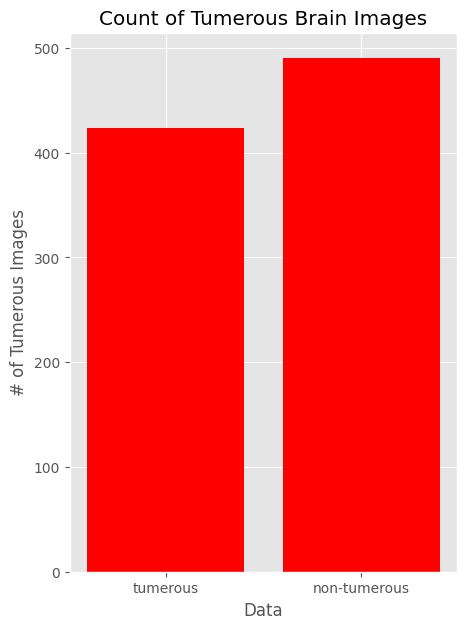

In [ ]:
# New Plot

data = {'tumerous': number_files_yes, 'non-tumerous': number_files_no}

typex = data.keys()
values = data.values()

fig = plt.figure(figsize=(5,7))
plt.bar(typex, values, color="red")
plt.xlabel("Data")
plt.ylabel("# of Tumerous Images")
plt.title("Count of Tumerous Brain Images")

# 7) Data Preprocessing

In [ ]:
# Convert BGR to GRAY
# GaussianBlur
# Threshold
# Erode
# Dilate
# Find Contours

In [19]:
import imutils
import cv2

def crop_brain_tumor(image, plot=False):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5,5), 0)

    thres = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thres =cv2.erode(thres, None, iterations = 2)
    thres = cv2.dilate(thres, None, iterations = 2)

    cnts = cv2.findContours(thres.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key = cv2.contourArea)

    extLeft = tuple(c[c[:,:,0].argmin()][0])
    extRight = tuple(c[c[:,:,0].argmax()][0])
    extTop = tuple(c[c[:,:,1].argmin()][0])
    extBot = tuple(c[c[:,:,1].argmax()][0])

    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Original Image')

        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        plt.show()

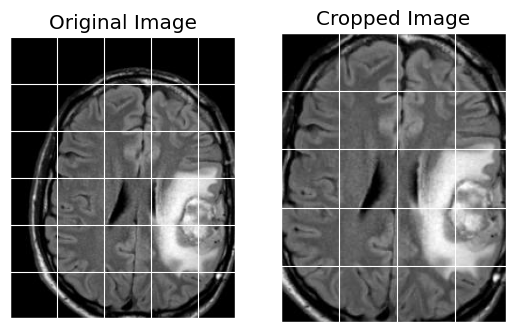

In [25]:
# Tumerous MRI Scan Cropped
img = cv2.imread('/Gdrive/MachineLearningProject/data/augmented_data/yes/aug_Y_15_0_1197.jpg')
crop_brain_tumor(img, True)

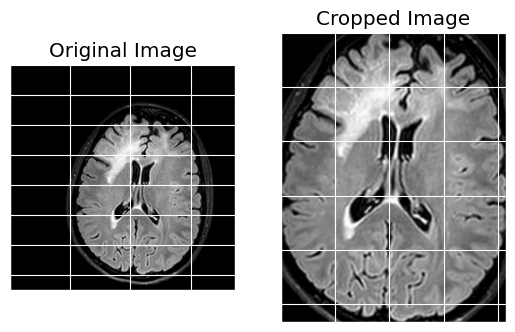

In [50]:
# Non-Tumerous MRI Scan Cropped
img = cv2.imread('/Gdrive/MachineLearningProject/data/augmented_data/no/aug_N_38_0_3762.jpg')
crop_brain_tumor(img, True)

# 8) Image Resizing

In [51]:
from sklearn.utils import shuffle
import cv2
import os
import numpy as np

augmeneted_yes = '/Gdrive/MachineLearningProject/data/augmented_data/yes/'
augmeneted_no = '/Gdrive/MachineLearningProject/data/augmented_data/no/'

tumerous=[]
non_tumerous=[]

for filename in os.listdir(augmeneted_yes):
    img = cv2.imread(augmeneted_yes + '/' + filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128,128))
    tumerous.append((img,1))
print("Tumerous Images Resized!")

for filename in os.listdir(augmeneted_no):
    img = cv2.imread(augmeneted_no + '/' + filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128,128))
    non_tumerous.append((img,0))
print("Non-Tumerous Images Resized!")

tumerous = np.array(tumerous, dtype=object)
non_tumerous = np.array(non_tumerous, dtype=object)

X_tumerous = np.array([item[0] for item in tumerous])
y_tumerous = np.array([item[1] for item in tumerous])

X_non_tumerous = np.array([item[0] for item in non_tumerous])
y_non_tumerous = np.array([item[1] for item in non_tumerous])

print(f"Tumerous image data shape: {X_tumerous.shape}")
print(f"Tumerous labels shape: {y_tumerous.shape}")

print(f"Non-Tumerous image data shape: {X_non_tumerous.shape}")
print(f"Non-Tumerous labels shape: {y_non_tumerous.shape}")

X = np.concatenate((X_tumerous, X_non_tumerous))
y = np.concatenate((y_tumerous, y_non_tumerous))

X, y = shuffle(X, y)

random_state = 42  # Set a random state for reproducibility
tumerous = shuffle(tumerous, random_state=random_state)
non_tumerous = shuffle(non_tumerous, random_state=random_state)

print(f"Number of examples is : {len(X)}")
print(f"X SHAPE is : {X.shape}")
print(f"y SHAPE is : {y.shape}")

Tumerous Images Resized!
Non-Tumerous Images Resized!
Tumerous image data shape: (424, 128, 128, 3)
Tumerous labels shape: (424,)
Non-Tumerous image data shape: (490, 128, 128, 3)
Non-Tumerous labels shape: (490,)
Number of examples is : 914
X SHAPE is : (914, 128, 128, 3)
y SHAPE is : (914,)


# 9) Plots of Cropped Data

In [52]:
def plot_sample_images(tumerous, non_tumerous, n=50):

    for label in [0,1]:
        images = X[np.argwhere(y == label)]
        n_images = images[:n]

        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))

        i = 1
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])

            plt.tick_params(axis='both', which='both',
                            top=False, bottom=False, left=False, right=False,
                            labelbottom=False, labeltop=False, labelleft=False,
                            labelright=False)

            i += 1

        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

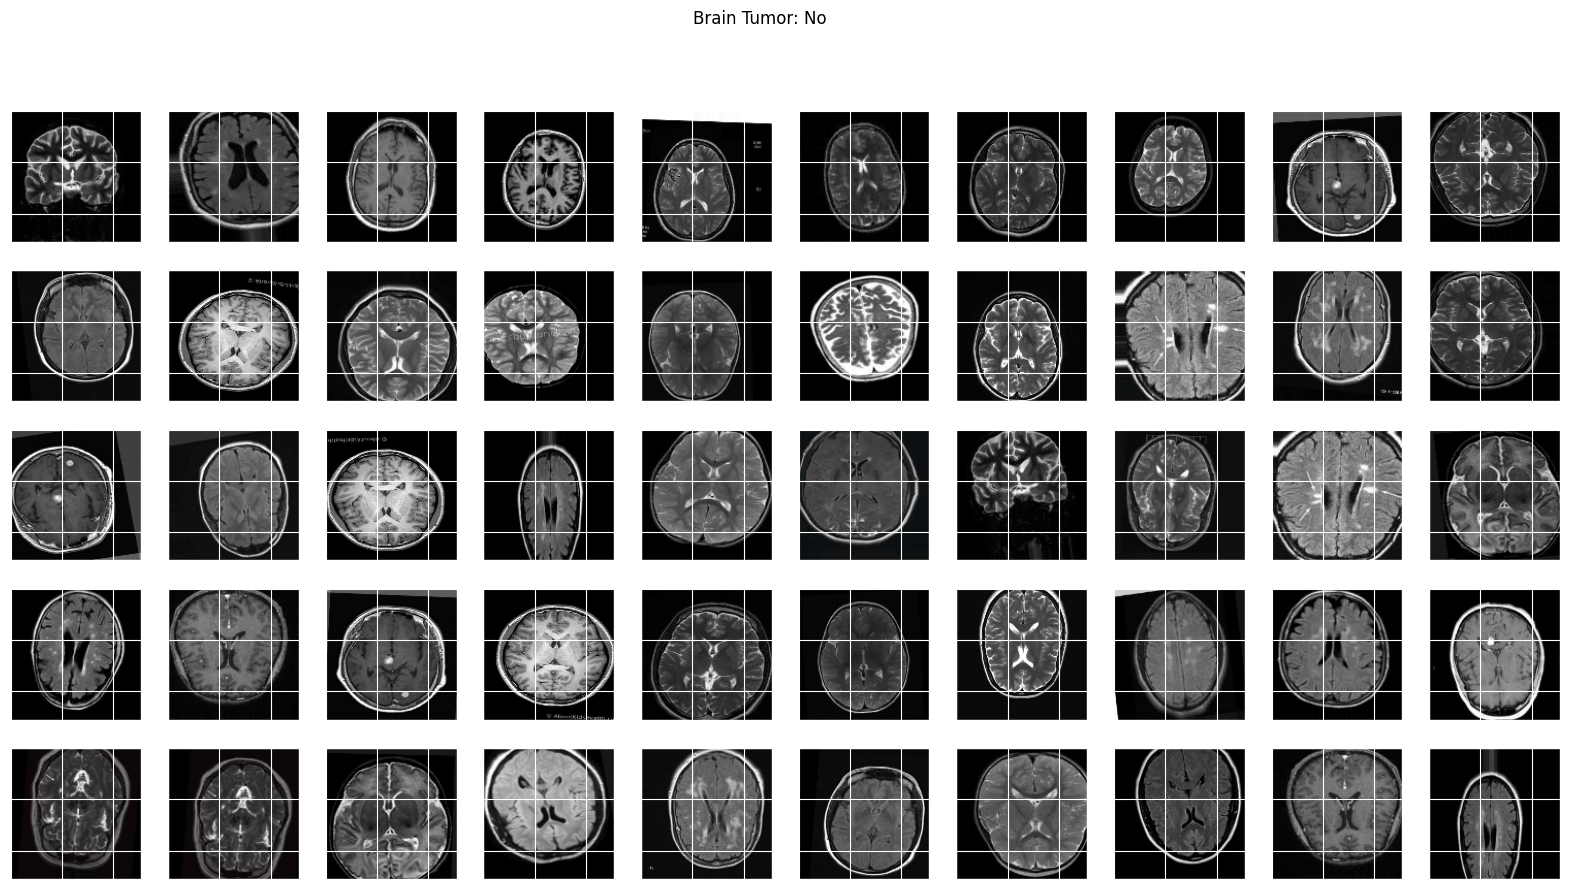

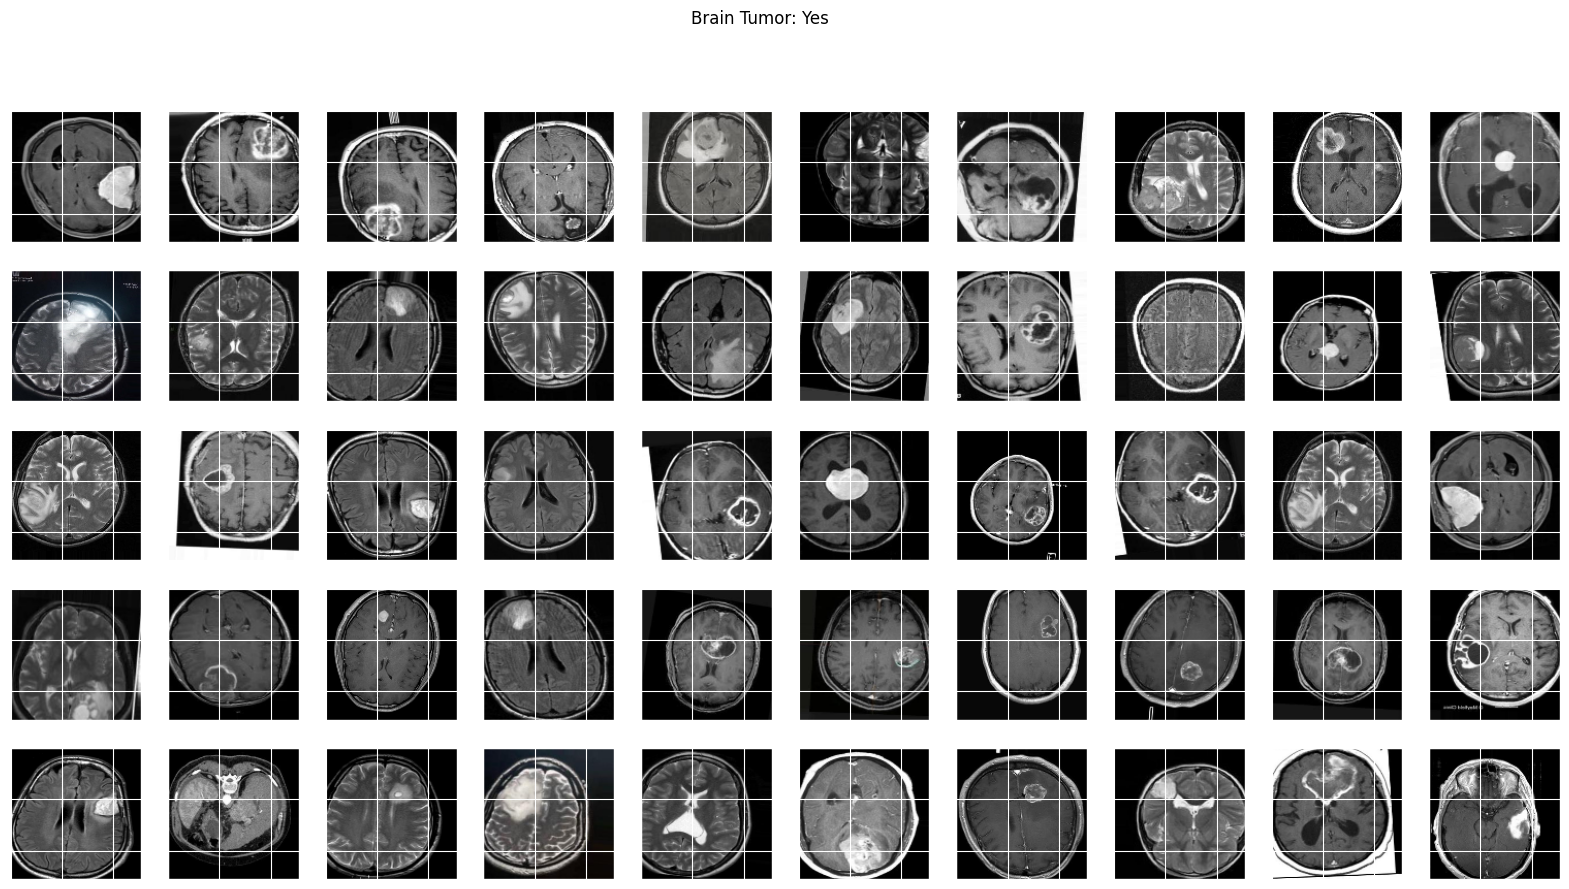

In [53]:
plot_sample_images(tumerous, non_tumerous)

# 10) Data Splitting into 3 Sets

In [ ]:
# Training Set
# Validation Set
# Testing Set

In [67]:
# Creating Base Directory for the Sets
if not os.path.isdir('/Gdrive/MachineLearningProject/data/tumerous_and_nontumerous/'):
  base_dir = '/Gdrive/MachineLearningProject/data/tumerous_and_nontumerous/'
  os.mkdir(base_dir)

In [69]:
# Creating the 3 Sets
if not os.path.isdir('/Gdrive/MachineLearningProject/data/tumerous_and_nontumerous/training'):
  training_dir = os.path.join(base_dir + 'training')
  os.mkdir(training_dir)
if not os.path.isdir('/Gdrive/MachineLearningProject/data/tumerous_and_nontumerous/testing'):
  testing_dir = os.path.join(base_dir + 'testing')
  os.mkdir(testing_dir)
if not os.path.isdir('/Gdrive/MachineLearningProject/data/tumerous_and_nontumerous/validation'):
  validation_dir = os.path.join(base_dir + 'validation')
  os.mkdir(validation_dir)

In [72]:
# Creating the tumerous folder in each set
if not os.path.isdir('/Gdrive/MachineLearningProject/data/tumerous_and_nontumerous/training/tumerous'):
  infected_training_dir = os.path.join(training_dir, 'tumerous')
  os.mkdir(infected_training_dir)
if not os.path.isdir('/Gdrive/MachineLearningProject/data/tumerous_and_nontumerous/testing/tumerous'):
  infected_testing_dir = os.path.join(testing_dir, 'tumerous')
  os.mkdir(infected_testing_dir)
if not os.path.isdir('/Gdrive/MachineLearningProject/data/tumerous_and_nontumerous/validation/tumerous'):
  infected_validation_dir = os.path.join(validation_dir, 'tumerous')
  os.mkdir(infected_validation_dir)

In [73]:
# Creating the Non_tumerous folder in each set
if not os.path.isdir('/Gdrive/MachineLearningProject/data/tumerous_and_nontumerous/training/non_tumerous'):
  healthy_training_dir = os.path.join(training_dir, 'non_tumerous')
  os.mkdir(healthy_training_dir)
if not os.path.isdir('/Gdrive/MachineLearningProject/data/tumerous_and_nontumerous/testing/non_tumerous'):
  healthy_testing_dir = os.path.join(testing_dir, 'non_tumerous')
  os.mkdir(healthy_testing_dir)
if not os.path.isdir('/Gdrive/MachineLearningProject/data/tumerous_and_nontumerous/validation/non_tumerous'):
  healthy_validation_dir = os.path.join(validation_dir, 'non_tumerous')
  os.mkdir(healthy_validation_dir)

In [75]:
original_dataset_tumerous = os.path.join('/Gdrive/MachineLearningProject/data/augmented_data/yes/')
original_dataset_non_tumerous = os.path.join('/Gdrive/MachineLearningProject/data/augmented_data/no/')

files = os.listdir('/Gdrive/MachineLearningProject/data/augmented_data/yes/')
fnames = []

# Yes Files: 424
# No Files: 490
# Total Samples: 914

for i in range(0,296):
  fnames.append(files[i])
for fname in fnames:
  src = os.path.join(original_dataset_tumerous, fname)
  dst = os.path.join(infected_training_dir, fname)
  shutil.copyfile(src, dst)

In [76]:
for i in range(296,424):
  fnames.append(files[i])
for fname in fnames:
  src = os.path.join(original_dataset_tumerous, fname)
  dst = os.path.join(infected_testing_dir, fname)
  shutil.copyfile(src, dst)

In [78]:
for i in range(424,490):
  fnames.append(files[i])
for fname in fnames:
  src = os.path.join(original_dataset_tumerous, fname)
  dst = os.path.join(infected_validation_dir, fname)
  shutil.copyfile(src, dst)